# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [2]:
df = pd.read_excel('./data/HIST_PAINEL_COVIDBR_18jun2020.xlsx')

## Tratamento inicial dos dados

In [3]:
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [5]:
uf = 'MS'
Muni = 'Dourados'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def semana_epi_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [7]:
df_est, df_est_sem, df_cidade, df_cidade_sem = semana_epi_df(df, uf, Muni)

### Função Grafico de casos por dia

In [42]:
def casos_dia_local(df, local):
    df.sort_values('data', inplace = True)
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'casosNovos', data=df, color= ['r','g', 'b', 'm', 'y', 'c', 'k'], width=.8)
    str(df['data'].dt.day.max())
    plt.savefig( './data/output/' + local + '_dia_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    
    print(df.loc[:,['casosNovos', 'data']].tail(14))

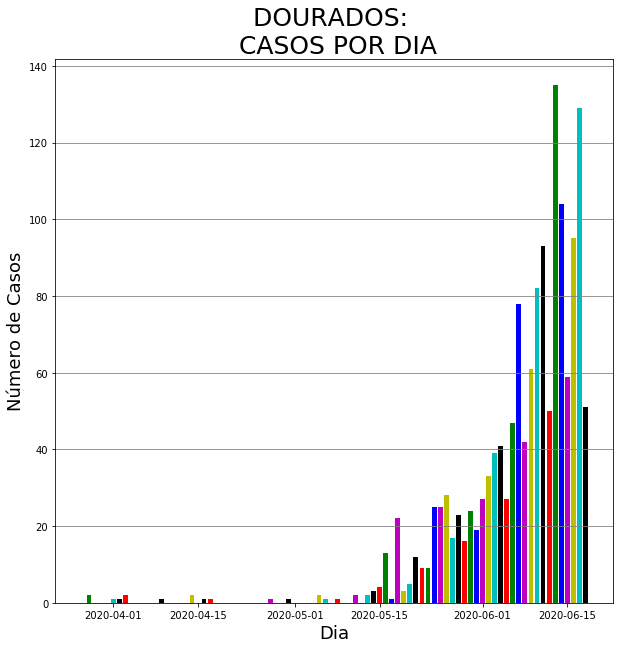

casosNovos       data
383390          27 2020-06-05
383391          47 2020-06-06
383392          78 2020-06-07
383393          42 2020-06-08
383394          61 2020-06-09
383395          82 2020-06-10
383396          93 2020-06-11
383397          50 2020-06-12
383398         135 2020-06-13
383399         104 2020-06-14
383400          59 2020-06-15
383401          95 2020-06-16
383402         129 2020-06-17
383403          51 2020-06-18


In [43]:
casos_dia_local(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [38]:
def casos_semana_local(df, local):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( './data/output/' + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print(df.loc[:,['semanaEpi','casosNovos']])

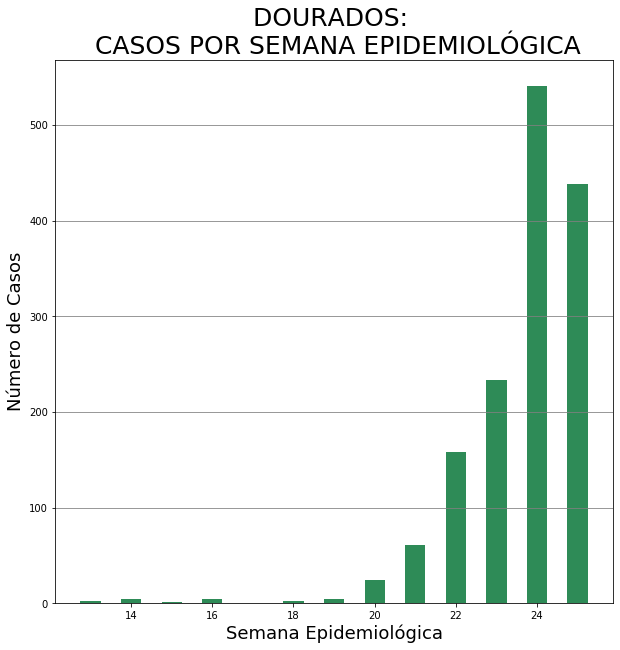

semanaEpi  casosNovos
0          13           2
1          14           4
2          15           1
3          16           4
4          17           0
5          18           2
6          19           4
7          20          24
8          21          61
9          22         158
10         23         233
11         24         541
12         25         438


In [39]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [12]:
def obitos_semana_local(df, local):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( './data/output/' + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    #plt.plot(df['semanaEpi'], df['obitosNovos'], color = 'darkred')

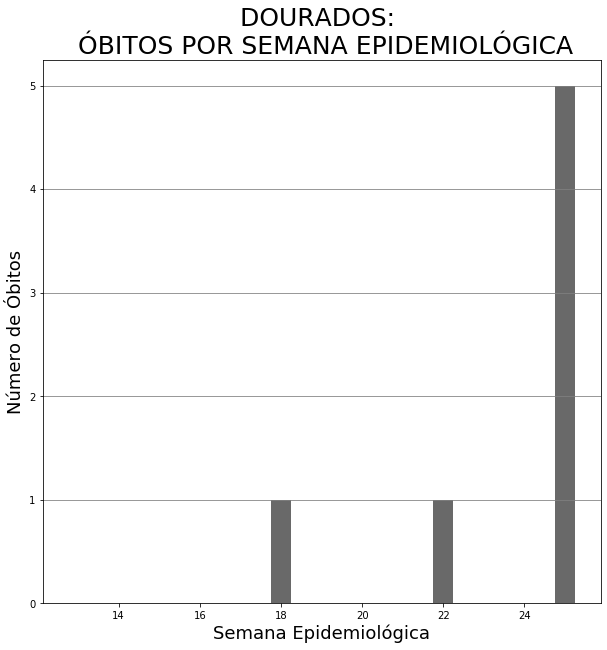

In [13]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [14]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\data\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\GitRepos\graficos_covid


'd:\\GitRepos\\graficos_covid\\data\\geojsonDL\\MS.json'

### Carregando arquivo GeoJson do estado

In [15]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

In [16]:
mapa.bounds

minx      miny      maxx      maxy
0  -58.16705 -20.94829 -55.13855 -17.16619
1  -58.00808 -22.18145 -56.62454 -20.24143
2  -57.67681 -19.19685 -57.46451 -18.99975
3  -57.51596 -22.25026 -56.75826 -21.55709
4  -57.06809 -20.65662 -56.12300 -19.61881
..       ...       ...       ...       ...
73 -52.59980 -19.37547 -51.53930 -18.74339
74 -52.51547 -20.12894 -51.47514 -19.19075
75 -52.11869 -20.61793 -51.34307 -19.91564
76 -51.87536 -19.96388 -50.92243 -19.13915
77 -51.68802 -20.35517 -50.99900 -19.79022

[78 rows x 4 columns]

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [17]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*1000 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid - {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( './data/output/' + uf.upper() + '_semana_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

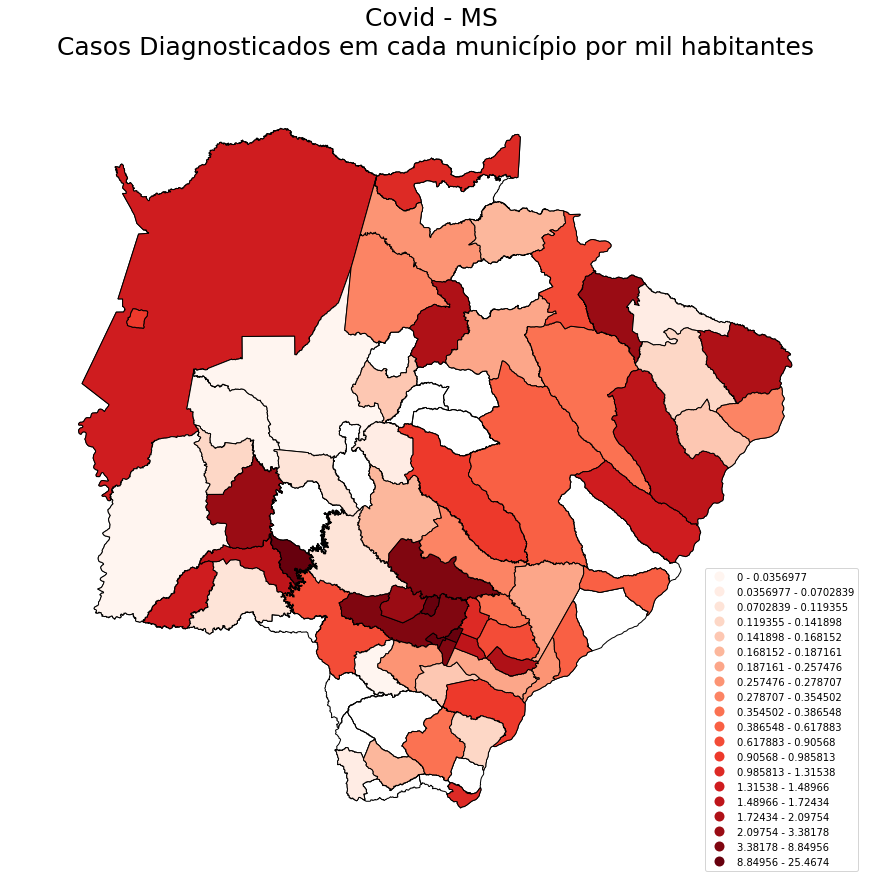

In [18]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

In [19]:
def mapa_obitos_estado(df, df_geo, uf, nLevels):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*1000 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid - {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( './data/output/' + uf.upper() + '_semana_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


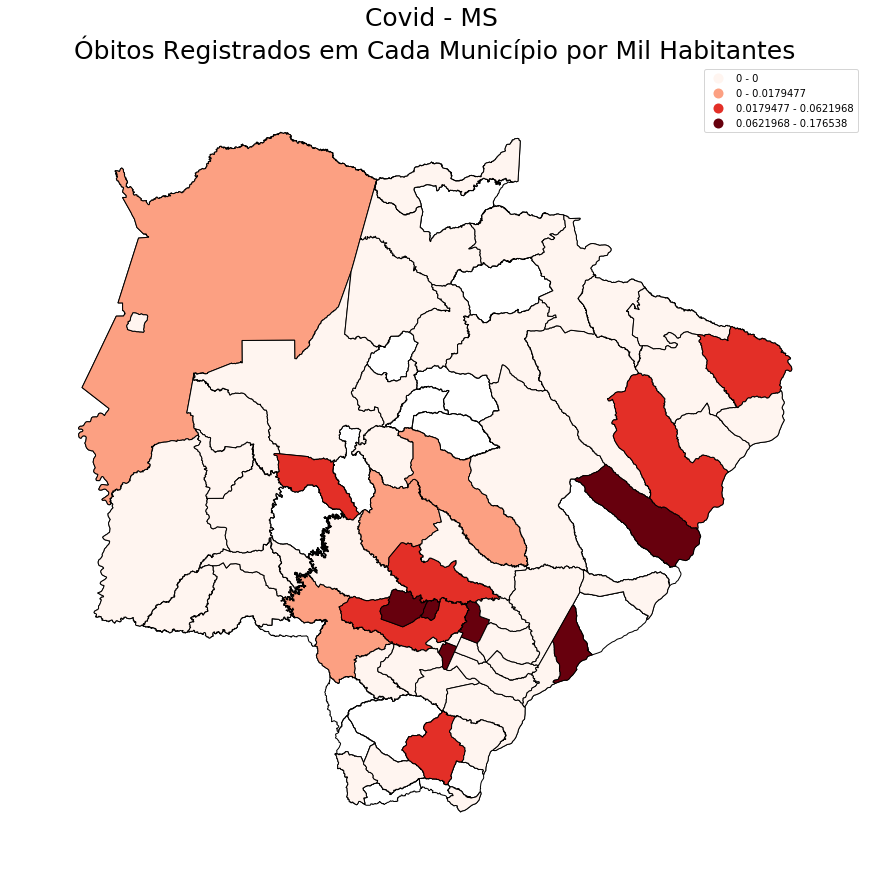

In [20]:
mapa_obitos_estado(df_est, mapa, uf, 10)